In [3]:
import pandas as pd
import quandl
import datetime
import matplotlib.pyplot as plt     # matplotlib for pandas.Dataframe.plot()

In [4]:
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

Populating the interactive namespace from numpy and matplotlib


In [5]:
# setup parameters for quandl.get()
start = datetime.datetime(2018, 1, 1)
end = datetime.date.today()

# Use quandl API key to authenticate (https://docs.quandl.com)
quandl.ApiConfig.api_key = "zo1ZDyAjozzqeivpjCin"

In [6]:
# get stock data for ticker
apple = quandl.get("WIKI/AAPL", start_date=start, end_date=end)
# list info
apple.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-01-02,170.16,172.30,169.26,172.26,25048048.0,0.0,1.0,170.16,172.30,169.26,172.26,25048048.0
2018-01-03,172.53,174.55,171.96,172.23,28819653.0,0.0,1.0,172.53,174.55,171.96,172.23,28819653.0
2018-01-04,172.54,173.47,172.08,173.03,22211345.0,0.0,1.0,172.54,173.47,172.08,173.03,22211345.0
2018-01-05,173.44,175.37,173.05,175.00,23016177.0,0.0,1.0,173.44,175.37,173.05,175.00,23016177.0
2018-01-08,174.35,175.61,173.93,174.35,20134092.0,0.0,1.0,174.35,175.61,173.93,174.35,20134092.0


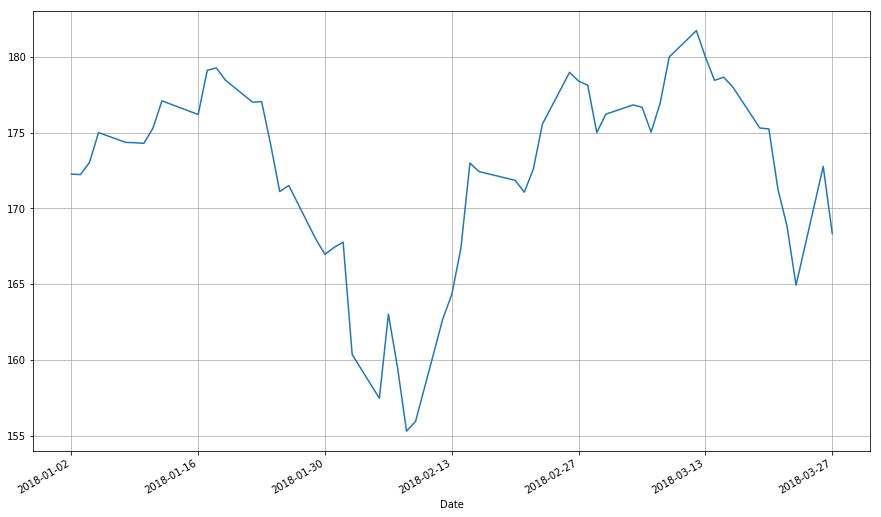

In [7]:
# plot adjusted closing price
apple["Adj. Close"].plot(grid = True)